In [1]:
# Importing libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import functions
from GP_action import GP_action
import time
import imageio
import pickle
import math
from turbo_1 import Turbo1
import time
import matplotlib


In [2]:
Noise=False# Specify if noisy or not
Noise_level= 0.05 # if noisy, what is the noise sd
'''If the scaled X and Y is being used rememeber to scale the noise as well'''

'If the scaled X and Y is being used rememeber to scale the noise as well'

In [3]:
# The target function is assigned, chose 1 from the below

objective=functions.Rosenbrock()
objective=functions.Synthetic()
objective=functions.sin()
objective=functions.sin_2(Noise,Noise_level)
objective=functions.sincos(Noise,Noise_level)
objective=functions.Branin()
objective=functions.Shubert(Noise,Noise_level)
objective=functions.Kean(Noise,Noise_level)
objective=functions.Shubert()
objective=functions.Kean(Noise,Noise_level)
objective=functions.Hartmann_3()
objective=functions.Hartmann_6()
objective=functions.Ackley_6()
objective=functions.Ackley_6()
objective=functions.Levy_10()
objective=functions.Rastrigin()


print(objective.bounds)
# Extracting the bounded range of the inputs
#func_bounds=bounds=np.array(
#            [item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])],dtype=np.float)
func_bounds=np.array(objective.bounds)
print(func_bounds)
#print(objective.func(np.array([0,0,0,0,0,0,0,0,0,0])))


[(-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4), (-3, 4)]
[[-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]
 [-3  4]]


In [4]:
class Levy:
    def __init__(self, dim=20):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        
    def __call__(self, coord):
        if(coord.ndim==1):
            coord=coord[np.newaxis,:]
        first = 1 + (coord[:,0]- 1.0) / 4.0
        last=1 + (coord[:,self.dim-1]- 1.0) / 4.0
        constant= np.sin(np.pi * first) ** 2
        sum_val=0
        for i in range(0,self.dim-1):
            w= 1 + (coord[:,i]- 1.0) / 4.0
            sum_val=sum_val+ (w - 1) ** 2 * (1 + 10 * np.sin(np.pi * w + 1) ** 2) + (last - 1) ** 2 * (1 + np.sin(2 * np.pi * w)**2)
        
        output=constant+sum_val
        return np.squeeze(output)

class Rastrigin:
    def __init__(self, dim=20):
        self.dim = dim
        self.lb = -3 * np.ones(dim)
        self.ub =  4 * np.ones(dim)
        
    def __call__(self, coord):
        if(coord.ndim==1):
            coord=coord[np.newaxis,:]

        first = 10*self.dim
        sum_val=0
        for i in range(0,self.dim):
            sum_val=sum_val+(coord[:,i]**2 - 10 * np.cos(2*np.pi*coord[:,i]))
        output=first+sum_val
        return np.squeeze(1*output)
    
class Ackley:
    def __init__(self, dim=20):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub =  10 * np.ones(dim)
        
    def __call__(self, coord):
        if(coord.ndim==1):
            coord=coord[np.newaxis,:]
        firstSum = 0.0
        secondSum = 0.0
        for i in range(0,self.dim):
            c=coord[:,i]
            firstSum += c**2.0
            secondSum += np.cos(2.0*math.pi*c)
        n = float(self.dim)
        return np.squeeze(-20.0*np.exp(-0.2*np.sqrt(firstSum/n)) - np.exp(secondSum/n) + 20 + math.e)
       
    
f = Rastrigin(20)

In [5]:
# max budget for finding good point

# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES','GD']
acquation_function='gp_ucb'
function_bounds=func_bounds
func_name='Levy'
Max= 0 # function max 3.86278, 3.32237
Max_eval=300
n_dim=20 # No of initial points
Budget=Max_eval+n_dim-1

In [6]:
turbo1 = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=n_dim,  # Number of initial bounds from an Latin hypercube design
    max_evals = Budget,  # Maximum number of evaluations
    batch_size=1,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=False,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cpu


In [7]:

#acq=['GD','gp_ucb','EI','TS']
time_opt=np.array([]) 
acq=['Turbo','GD','GD_Turbo']
Mean_dict = {} 
std_dict={}
k=0
mean=np.zeros(Max_eval)
std=np.zeros(Max_eval)
seed=np.random.randint(10000, size=5)
initial_X=np.array([])
while(k<3):
    temp_out=np.zeros(Max_eval)
    seed_count=0
    start_opt=time.time()
    for m in range(0,5):
        samples=[]
        acquation_function=acq[k]
        if(acquation_function=='Turbo'):
            turbo1 = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=n_dim,  # Number of initial bounds from an Latin hypercube design
    max_evals = Budget,  # Maximum number of evaluations
    batch_size=1,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=False,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)
            turbo1.optimize()
            X_temp=turbo1.X[0:n_dim]
            if(m==0):
                initial_X=X_temp
            else:
                initial_X=np.vstack((initial_X,X_temp))
            Y_value=np.array([])
            j=n_dim
            while(j<=Budget):
                Y_value=np.append(Y_value,np.min(np.squeeze(turbo1.fX[:j])))
                j=j+1
            samples=Y_value-Max
        else:
            seeds=seed[seed_count]
            Bo_test=GP_action(objective.func,function_bounds,Noise,Noise_level,acquation_function)
            X_start=initial_X[m*n_dim:(m+1)*n_dim]
            Bo_test.initiate(X_start,n_dim)
         #   Bo_test.initiate(seeds,n_random_draws=5)
            seed_count=seed_count+1
            flag = True
            i = 0
            samples.append(Max-np.max(Bo_test.Y))
            while flag:
                if i >= (Max_eval-1) :
                    break
                Bo_test.sample_new_value()
                Regret= Max-np.max(Bo_test.Y)
                samples.append(Regret)
                i += 1
        out=np.array(samples)
        temp_out=np.vstack((temp_out, out))
    finished_opt=time.time()
    time_opt=np.append(time_opt,finished_opt-start_opt)
    temp_out = np.delete(temp_out,(0), axis=0)
    mean_temp=np.mean(temp_out,axis=0)
    std_temp=0.5*np.sqrt(np.var(temp_out,axis=0)) # Calculating the one sided interval for 90% confidence

    mean=np.vstack((mean,mean_temp))
    std=np.vstack((std,std_temp))
    Mean_dict[acquation_function]=mean_temp
    std_dict[acquation_function]=std_temp
    k=k+1
    


Using dtype = torch.float64 
Using device = cpu


Starting from fbest = 205.3


54) New best: 203.9


100) New best: 197.4


102) New best: 183.8


126) New best: 182.7


128) New best: 176.1


131) New best: 167.7


134) New best: 157.4


140) New best: 151.8


146) New best: 134.9


158) New best: 132.8


160) New best: 124.8


168) New best: 115.6


170) New best: 114.4


189) New best: 101.1


211) New best: 96.71


224) New best: 91.05


241) New best: 87.33


264) New best: 86.36


272) New best: 84.77


292) Restarting with fbest = 84.77


Starting from fbest = 235.3


Using dtype = torch.float64 
Using device = cpu


Starting from fbest = 208.2


44) New best: 191.7


70) New best: 178.8


80) New best: 170.8


115) New best: 166.0


131) New best: 161.3


137) New best: 142.5


150) New best: 131.0


171) New best: 130.3


178) New best: 128.9


179) New best: 109.6


183) New best: 105.5


187) New best: 101.4


194) New best: 93.01


202) New best: 72.37


225) New best: 66.18


228) New best: 58.01


250) New best: 57.96


254) New best: 57.76


271) New best: 57.07


275) New best: 54.67


280) New best: 54.56


282) New best: 54.46


283) New best: 53.81


286) New best: 53.67


295) New best: 53.14


302) New best: 52.07


305) New best: 51.71


311) New best: 50.8


315) New best: 50.51


Using dtype = torch.float64 
Using device = cpu


Starting from fbest = 237.2


23) New best: 233.8


42) New best: 207.2


58) New best: 203.1


119) New best: 199.3


120) New best: 162.1


143) New best: 153.0


145) New best: 142.3


146) New best: 139.3


155) New best: 135.0


157) New best: 109.8


167) New best: 99.08


169) New best: 98.26


185) New best: 90.74


198) New best: 88.97


213) New best: 81.63


217) New best: 80.63


220) New best: 78.69


249) New best: 76.74


254) New best: 72.48


255) New best: 70.11


258) New best: 68.09


278) New best: 64.62


306) New best: 64.13


310) New best: 62.18


Using dtype = torch.float64 
Using device = cpu


Starting from fbest = 211.8


43) New best: 194.3


112) New best: 187.4


116) New best: 183.5


119) New best: 182.0


127) New best: 164.3


135) New best: 159.7


141) New best: 154.4


147) New best: 141.1


151) New best: 136.1


153) New best: 132.5


164) New best: 127.5


176) New best: 118.5


177) New best: 113.4


198) New best: 105.5


200) New best: 104.6


212) New best: 104.6


213) New best: 94.32


216) New best: 92.21


227) New best: 89.35


242) New best: 88.71


270) New best: 88.16


281) New best: 87.73


282) New best: 84.21


284) New best: 80.66


303) New best: 79.33


304) New best: 78.05


309) New best: 76.09


312) New best: 74.72


313) New best: 74.66


Using dtype = torch.float64 
Using device = cpu


Starting from fbest = 224.7


23) New best: 194.0


35) New best: 189.0


49) New best: 174.3


131) New best: 155.2


133) New best: 147.2


137) New best: 134.4


143) New best: 129.8


147) New best: 98.41


153) New best: 94.73


159) New best: 81.71


173) New best: 81.42


196) New best: 75.66


198) New best: 72.8


199) New best: 66.44


200) New best: 65.05


226) New best: 64.76


227) New best: 61.94


233) New best: 58.3


246) New best: 58.2


247) New best: 57.75


251) New best: 55.71


272) New best: 55.64


276) New best: 54.09


277) New best: 53.36


297) Restarting with fbest = 53.36


Starting from fbest = 220.0


0) Start Val: -205.3


7


7


7


7


7


7


Restart
7


7


7


10) Grad Step: -214.6


7


11) Grad Step: -168.2


7


7


7


7


7


7


Restart
7


19) Grad Step: -279.0


7


7


7


7


7


24) Grad Step: -198.8


7


7


7


7


7


7


Restart
7


32) Grad Step: -262.9


7


7


34) Grad Step: -148.3


7


7


7


7


7


7


Restart
7


42) Grad Step: -301.4


7


43) Grad Step: -275.8


7


44) Grad Step: -274.4


7


7


7


7


7


7


50) Grad Step: -264.6


7


51) Grad Step: -236.2


7


7


7


7


7


7


Restart
7


59) Grad Step: -272.7


7


7


7


7


7


7


Restart
7


67) Grad Step: -260.8


7


7


7


7


71) Grad Step: -238.2


7


7


7


74) Grad Step: -205.6


7


7


7


7


7


7


Restart
7


82) Grad Step: -261.8


7


83) Grad Step: -254.7


7


7


7


7


7


7


Restart
7


91) Grad Step: -271.9


7


7


93) Grad Step: -230.9


7


7


7


96) Grad Step: -216.7


7


7


7


99) Grad Step: -164.2


7


100) Grad Step: -159.6


7


7


7


7


7


7


106) Grad Step: -129.3


7


7


108) Grad Step: -123.5


7


7


7


111) Grad Step: -111.1


7


7


7


7


7


7


Restart
7


119) Grad Step: -269.2


7


120) Grad Step: -262.1


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


142) Grad Step: -316.0


7


143) Grad Step: -283.0


7


144) Grad Step: -277.1


7


7


7


147) Grad Step: -181.5


7


7


7


150) Grad Step: -65.2


7


7


152) Grad Step: -29.83


7


7


7


7


7


7


Restart
7


160) Grad Step: -252.3


7


7


7


7


7


7


Restart
7


7


169) Grad Step: -265.1


7


170) Grad Step: -237.2


7


7


7


7


7


7


Restart
7


7


179) Grad Step: -273.6


7


180) Grad Step: -237.0


7


7


7


7


7


7


Restart
7


7


189) Grad Step: -239.4


7


190) Grad Step: -219.7


7


7


7


7


194) Grad Step: -183.3


7


195) Grad Step: -138.3


7


7


197) Grad Step: -42.97


7


7


7


7


7


7


Restart
7


205) Grad Step: -237.0


7


206) Grad Step: -214.6


7


7


7


7


7


7


Restart
7


7


7


216) Grad Step: -247.4


7


7


7


7


220) Grad Step: -123.1


7


7


7


7


7


7


Restart
7


228) Grad Step: -303.4


7


229) Grad Step: -289.4


7


7


231) Grad Step: -225.1


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


253) Grad Step: -217.6


7


7


255) Grad Step: -166.6


7


7


7


7


7


7


Restart
7


7


264) Grad Step: -183.1


7


7


7


7


268) Grad Step: -147.2


7


7


7


7


7


7


Restart
7


276) Grad Step: -321.0


7


277) Grad Step: -270.8


7


7


279) Grad Step: -232.2


7


7


7


7


7


7


285) Grad Step: -226.3


7


7


287) Grad Step: -205.8


7


7


289) Grad Step: -52.59


7


7


7


7


7


7


Restart
7


7


7


0) Start Val: -208.2


7


1) Grad Step: -197.0


7


7


7


4) Grad Step: -95.79


7


7


7


7


8) Grad Step: -48.61


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


23) Grad Step: -265.7


7


7


7


7


7


7


Restart
7


7


32) Grad Step: -256.9


7


33) Grad Step: -147.5


7


7


7


7


7


7


Restart
7


41) Grad Step: -294.7


7


42) Grad Step: -253.6


7


7


7


45) Grad Step: -245.2


7


46) Grad Step: -227.7


7


7


48) Grad Step: -179.5


7


7


7


7


7


7


Restart
7


7


57) Grad Step: -254.3


7


58) Grad Step: -206.8


7


7


7


7


7


7


Restart
7


7


67) Grad Step: -148.2


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


7


83) Grad Step: -257.0


7


7


85) Grad Step: -222.0


7


7


7


7


7


7


Restart
7


93) Grad Step: -289.7


7


94) Grad Step: -270.1


7


7


7


7


7


7


Restart
7


102) Grad Step: -251.7


7


7


7


7


7


7


Restart
7


110) Grad Step: -241.7


7


7


7


113) Grad Step: -216.0


7


7


7


7


7


7


Restart
7


121) Grad Step: -260.3


7


7


7


7


7


7


Restart
7


129) Grad Step: -316.5


7


130) Grad Step: -279.9


7


7


7


133) Grad Step: -263.1


7


134) Grad Step: -209.7


7


7


7


7


7


7


Restart
7


7


7


144) Grad Step: -263.6


7


7


7


7


148) Grad Step: -174.0


7


7


7


7


7


7


Restart
7


156) Grad Step: -198.1


7


7


7


7


7


7


Restart
7


164) Grad Step: -296.3


7


7


166) Grad Step: -148.7


7


7


7


7


7


171) Grad Step: -130.5


7


7


173) Grad Step: -117.9


7


7


7


7


177) Grad Step: -62.9


7


7


7


7


7


7


Restart
7


185) Grad Step: -263.8


7


7


7


7


7


7


Restart
7


7


194) Grad Step: -148.3


7


7


7


7


7


199) Grad Step: -84.49


7


7


7


7


7


7


Restart
7


207) Grad Step: -306.4


7


7


7


7


7


7


Restart
7


7


216) Grad Step: -261.5


7


7


218) Grad Step: -207.0


7


7


220) Grad Step: -197.5


7


7


7


7


224) Grad Step: -181.6


7


7


7


7


228) Grad Step: -43.98


7


7


7


7


7


7


Restart
7


236) Grad Step: -287.2


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


251) Grad Step: -254.5


7


7


7


254) Grad Step: -229.5


7


7


7


257) Grad Step: -216.6


7


7


7


7


7


262) Grad Step: -182.7


7


7


7


7


7


7


Restart
7


270) Grad Step: -275.2


7


271) Grad Step: -249.6


7


272) Grad Step: -225.7


7


7


7


7


7


7


Restart
7


280) Grad Step: -291.3


7


7


7


283) Grad Step: -263.2


7


7


7


7


7


288) Grad Step: -250.8


7


7


7


7


7


7


Restart
7


296) Grad Step: -232.3


7


7


7


0) Start Val: -237.2


7


7


2) Grad Step: -156.1


7


7


7


5) Grad Step: -37.22


7


7


7


7


7


7


Restart
7


13) Grad Step: -298.1


7


7


15) Grad Step: -180.9


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


30) Grad Step: -273.7


7


7


7


7


7


7


Restart
7


38) Grad Step: -240.6


7


7


40) Grad Step: -190.5


7


7


7


43) Grad Step: -69.41


7


7


7


7


7


7


Restart
7


7


52) Grad Step: -187.6


7


7


7


7


7


7


Restart
7


7


61) Grad Step: -237.3


7


7


7


7


7


7


Restart
7


69) Grad Step: -335.1


7


70) Grad Step: -307.5


7


71) Grad Step: -307.2


7


7


73) Grad Step: -199.1


7


7


7


7


7


7


Restart
7


7


82) Grad Step: -277.7


7


83) Grad Step: -164.7


7


7


85) Grad Step: -95.96


7


7


7


7


7


90) Grad Step: -58.6


7


7


7


7


7


7


Restart
7


98) Grad Step: -236.3


7


7


7


101) Grad Step: -214.1


7


7


7


7


7


7


Restart
7


7


110) Grad Step: -229.8


7


111) Grad Step: -226.6


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


126) Grad Step: -279.0


7


7


7


7


7


7


Restart
7


7


7


136) Grad Step: -279.5


7


137) Grad Step: -188.7


7


7


7


7


7


7


Restart
7


145) Grad Step: -254.8


7


7


7


7


7


7


Restart
7


153) Grad Step: -203.9


7


7


7


7


157) Grad Step: -167.4


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


172) Grad Step: -242.8


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


7


7


189) Grad Step: -188.2


7


7


7


7


7


7


Restart
7


7


198) Grad Step: -218.3


7


7


7


7


7


7


Restart
7


206) Grad Step: -235.4


7


7


7


7


210) Grad Step: -201.8


7


7


212) Grad Step: -160.1


7


7


214) Grad Step: -82.12


7


7


7


7


7


7


Restart
7


7


223) Grad Step: -183.8


7


7


7


7


7


7


Restart
7


7


232) Grad Step: -109.2


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


247) Grad Step: -277.8


7


248) Grad Step: -250.3


7


249) Grad Step: -244.7


7


7


7


7


7


7


Restart
7


7


7


259) Grad Step: -173.7


7


7


7


7


7


7


Restart
7


267) Grad Step: -240.7


7


7


269) Grad Step: -175.7


7


270) Grad Step: -155.4


7


7


272) Grad Step: -73.31


7


7


7


7


7


277) Grad Step: -70.1


7


7


7


7


7


7


Restart
7


7


7


7


288) Grad Step: -295.4


7


7


7


7


7


7


Restart
7


296) Grad Step: -242.2


7


7


7


0) Start Val: -211.8


7


7


2) Grad Step: -199.5


7


7


4) Grad Step: -162.4


7


7


6) Grad Step: -155.4


7


7


7


7


7


7


Restart
7


14) Grad Step: -222.3


7


7


7


7


18) Grad Step: -199.1


7


7


7


7


7


7


Restart
7


26) Grad Step: -261.0


7


27) Grad Step: -254.6


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


42) Grad Step: -243.5


7


7


7


7


46) Grad Step: -226.2


7


7


7


7


50) Grad Step: -220.7


7


7


7


7


7


55) Grad Step: -218.2


7


7


57) Grad Step: -208.3


7


7


7


7


7


7


63) Grad Step: -203.1


7


7


7


7


67) Grad Step: -185.8


7


7


7


7


7


7


Restart
7


7


76) Grad Step: -248.4


7


7


7


79) Grad Step: -195.0


7


7


7


7


7


7


Restart
7


87) Grad Step: -312.5


7


88) Grad Step: -289.5


7


7


90) Grad Step: -280.8


7


91) Grad Step: -208.1


7


7


7


7


7


7


Restart
7


99) Grad Step: -255.8


7


7


7


7


103) Grad Step: -173.5


7


7


7


7


7


7


Restart
7


111) Grad Step: -282.1


7


7


7


7


7


7


Restart
7


7


7


121) Grad Step: -215.6


7


7


7


7


7


7


Restart
7


7


130) Grad Step: -238.6


7


131) Grad Step: -195.3


7


7


7


7


7


7


Restart
7


7


7


141) Grad Step: -209.0


7


7


7


144) Grad Step: -180.9


7


7


7


7


7


7


150) Grad Step: -170.7


7


7


7


7


7


7


Restart
7


7


159) Grad Step: -266.3


7


7


161) Grad Step: -242.5


7


7


7


7


7


166) Grad Step: -214.8


7


7


7


169) Grad Step: -86.07


7


7


7


7


7


7


Restart
7


7


178) Grad Step: -212.7


7


7


7


7


7


183) Grad Step: -199.6


7


7


7


7


7


7


Restart
7


7


7


193) Grad Step: -263.3


7


194) Grad Step: -220.5


7


195) Grad Step: -199.4


7


7


197) Grad Step: -178.7


7


7


7


7


7


7


Restart
7


205) Grad Step: -328.8


7


206) Grad Step: -268.8


7


207) Grad Step: -264.2


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


7


223) Grad Step: -264.9


7


7


7


7


7


7


Restart
7


231) Grad Step: -278.3


7


7


233) Grad Step: -278.2


7


234) Grad Step: -270.8


7


7


236) Grad Step: -268.2


7


237) Grad Step: -220.2


7


238) Grad Step: -195.6


7


7


240) Grad Step: -116.6


7


7


7


7


7


7


Restart
7


7


249) Grad Step: -295.6


7


250) Grad Step: -230.5


7


251) Grad Step: -213.4


7


7


7


7


255) Grad Step: -199.3


7


7


7


7


7


7


Restart
7


263) Grad Step: -271.5


7


7


7


7


7


7


Restart
7


271) Grad Step: -281.7


7


7


7


7


7


276) Grad Step: -261.2


7


7


278) Grad Step: -78.49


7


7


7


7


7


7


Restart
7


7


287) Grad Step: -194.1


7


7


289) Grad Step: -194.0


7


7


7


7


Restart
7


7


296) Grad Step: -266.3


7


297) Grad Step: -226.5


7


7


0) Start Val: -224.7


7


7


7


7


7


7


6) Grad Step: -83.88


7


7


7


7


7


7


Restart
7


7


15) Grad Step: -288.3


7


7


7


7


7


20) Grad Step: -210.4


7


7


7


7


24) Grad Step: -140.3


7


7


7


7


28) Grad Step: -79.88


7


7


7


7


7


7


Restart
7


36) Grad Step: -297.7


7


7


7


7


40) Grad Step: -177.4


7


7


7


7


7


7


Restart
7


7


49) Grad Step: -194.2


7


7


7


7


7


7


Restart
7


7


58) Grad Step: -266.7


7


59) Grad Step: -246.7


7


7


61) Grad Step: -235.4


7


7


63) Grad Step: -200.8


7


64) Grad Step: -185.3


7


7


7


7


7


7


Restart
7


7


73) Grad Step: -161.5


7


7


75) Grad Step: -57.42


7


7


77) Grad Step: -47.52


7


7


7


7


7


7


Restart
7


7


86) Grad Step: -228.4


7


7


7


7


7


91) Grad Step: -205.0


7


7


7


7


7


96) Grad Step: -181.6


7


7


7


7


7


7


Restart
7


104) Grad Step: -250.8


7


7


106) Grad Step: -241.0


7


7


108) Grad Step: -232.1


7


109) Grad Step: -208.6


7


7


7


7


7


7


Restart
7


7


118) Grad Step: -207.1


7


7


7


7


7


7


Restart
7


7


127) Grad Step: -212.0


7


7


7


7


7


7


Restart
7


7


7


137) Grad Step: -77.38


7


7


7


7


7


7


Restart
7


145) Grad Step: -327.1


7


146) Grad Step: -207.0


7


7


7


7


7


7


152) Grad Step: -199.6


7


7


7


7


7


7


Restart
7


7


7


7


7


164) Grad Step: -234.2


7


165) Grad Step: -212.2


7


7


7


7


7


170) Grad Step: -162.3


7


7


7


7


7


7


Restart
7


178) Grad Step: -285.5


7


179) Grad Step: -263.1


7


7


181) Grad Step: -209.3


7


182) Grad Step: -194.2


7


7


7


7


7


7


Restart
7


190) Grad Step: -287.1


7


7


7


7


7


7


Restart
7


198) Grad Step: -287.5


7


7


7


7


7


7


Restart
7


7


207) Grad Step: -152.1


7


7


7


7


7


212) Grad Step: -134.0


7


7


214) Grad Step: -133.2


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


229) Grad Step: -289.5


7


7


7


7


233) Grad Step: -251.4


7


7


7


7


7


7


Restart
7


241) Grad Step: -269.2


7


7


7


244) Grad Step: -105.7


7


7


7


7


7


7


Restart
7


252) Grad Step: -221.1


7


7


7


255) Grad Step: -22.68


7


7


7


7


7


7


Restart
7


263) Grad Step: -272.9


7


264) Grad Step: -255.9


7


265) Grad Step: -231.1


7


7


7


7


7


7


Restart
7


7


7


7


7


7


Restart
7


280) Grad Step: -273.8


7


7


282) Grad Step: -234.4


7


7


7


7


7


7


Restart
7


290) Grad Step: -287.7


7


291) Grad Step: -225.6


7


7


293) Grad Step: -215.9


7


294) Grad Step: -208.2


7


295) Grad Step: -181.4


7


7


7


7


0) Start Val: -205.3


0.5


0.5


2) Grad Step: -118.6


0.5


3) Grad Step: -115.5


0.5


0.5


5) Grad Step: -31.95


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


17) Grad Step: -266.3


0.5


0.5


19) Grad Step: -257.3


0.5


20) Grad Step: -235.0


0.5


21) Grad Step: -207.6


0.5


22) Grad Step: -179.7


0.5


0.5


24) Grad Step: -149.3


0.5


25) Grad Step: -134.4


0.5


26) Grad Step: -124.3


0.5


0.5


28) Grad Step: -107.4


0.5


29) Grad Step: -84.06


0.5


30) Grad Step: -80.51


0.5


0.5


32) Grad Step: -25.32


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


45) Grad Step: -102.9


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


57) Grad Step: -231.5


0.5


0.5


0.5


0.5


0.5


62) Grad Step: -199.2


0.5


63) Grad Step: -91.29


0.5


64) Grad Step: -25.37


0.5


0.5


0.5


0.5


68) Grad Step: -22.86


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


0.5


7


85) Grad Step: -204.9


0.5


0.5


87) Grad Step: -101.3


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


100) Grad Step: -98.03


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


115) Grad Step: -257.4


0.5


116) Grad Step: -249.4


0.5


0.5


0.5


0.5


0.5


7


7


123) Grad Step: -236.7


0.5


0.5


125) Grad Step: -118.0


0.5


126) Grad Step: -48.5


0.5


127) Grad Step: -20.93


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


139) Grad Step: -309.2


0.5


140) Grad Step: -291.4


0.5


141) Grad Step: -287.6


0.5


0.5


0.5


0.5


145) Grad Step: -180.0


0.5


146) Grad Step: -147.1


0.5


147) Grad Step: -127.7


0.5


0.5


0.5


150) Grad Step: -110.0


0.5


0.5


0.5


153) Grad Step: -98.59


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


165) Grad Step: -294.9


0.5


166) Grad Step: -290.8


0.5


167) Grad Step: -285.8


0.5


168) Grad Step: -276.0


0.5


169) Grad Step: -267.2


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


182) Grad Step: -181.4


0.5


0.5


0.5


185) Grad Step: -180.5


0.5


0.5


0.5


0.5


189) Grad Step: -179.9


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


201) Grad Step: -221.3


0.5


0.5


0.5


0.5


0.5


7


7


7


209) Grad Step: -206.8


0.5


0.5


211) Grad Step: -36.71


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


223) Grad Step: -288.0


0.5


0.5


0.5


0.5


227) Grad Step: -95.92


0.5


228) Grad Step: -48.61


0.5


0.5


230) Grad Step: -41.97


0.5


0.5


0.5


233) Grad Step: -37.38


0.5


0.5


0.5


236) Grad Step: -35.88


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


248) Grad Step: -264.9


0.5


249) Grad Step: -258.0


0.5


250) Grad Step: -247.1


0.5


251) Grad Step: -244.4


0.5


0.5


253) Grad Step: -235.1


0.5


254) Grad Step: -221.5


0.5


255) Grad Step: -214.9


0.5


0.5


0.5


0.5


259) Grad Step: -211.8


0.5


0.5


0.5


262) Grad Step: -185.3


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


275) Grad Step: -64.47


0.5


276) Grad Step: -42.3


0.5


277) Grad Step: -32.87


0.5


278) Grad Step: -20.24


0.5


0.5


0.5


281) Grad Step: -13.88


0.5


0.5


283) Grad Step: -12.37


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


295) Grad Step: -304.7


0.5


296) Grad Step: -297.1


0.5


297) Grad Step: -281.0


0.5


0.5


0) Start Val: -208.2


0.5


0.5


0.5


0.5


0.5


7


7


7) Grad Step: -207.9


0.5


8) Grad Step: -193.5


0.5


0.5


0.5


0.5


12) Grad Step: -124.6


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


24) Grad Step: -287.7


0.5


25) Grad Step: -271.8


0.5


0.5


0.5


0.5


0.5


7


31) Grad Step: -187.8


0.5


0.5


33) Grad Step: -181.1


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


45) Grad Step: -308.7


0.5


46) Grad Step: -296.3


0.5


47) Grad Step: -294.8


0.5


0.5


0.5


0.5


51) Grad Step: -290.5


0.5


52) Grad Step: -194.5


0.5


53) Grad Step: -137.1


0.5


54) Grad Step: -117.1


0.5


0.5


56) Grad Step: -111.7


0.5


57) Grad Step: -107.3


0.5


0.5


0.5


60) Grad Step: -103.2


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


73) Grad Step: -79.79


0.5


74) Grad Step: -77.86


0.5


0.5


0.5


0.5


78) Grad Step: -61.03


0.5


0.5


0.5


81) Grad Step: -40.74


0.5


0.5


83) Grad Step: -35.83


0.5


0.5


85) Grad Step: -35.02


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


97) Grad Step: -288.0


0.5


98) Grad Step: -251.7


0.5


0.5


100) Grad Step: -189.3


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


110) Grad Step: -156.4


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


122) Grad Step: -271.9


0.5


123) Grad Step: -270.1


0.5


0.5


0.5


126) Grad Step: -240.1


0.5


127) Grad Step: -186.9


0.5


128) Grad Step: -151.3


0.5


0.5


0.5


0.5


132) Grad Step: -148.7


0.5


133) Grad Step: -98.9


0.5


134) Grad Step: -82.63


0.5


135) Grad Step: -81.06


0.5


0.5


137) Grad Step: -39.16


0.5


0.5


0.5


0.5


0.5


142) Grad Step: -21.07


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


154) Grad Step: -277.3


0.5


155) Grad Step: -260.1


0.5


0.5


0.5


158) Grad Step: -180.9


0.5


159) Grad Step: -138.4


0.5


160) Grad Step: -110.8


0.5


0.5


0.5


163) Grad Step: -104.0


0.5


0.5


0.5


166) Grad Step: -99.79


0.5


0.5


0.5


0.5


0.5


171) Grad Step: -89.52


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


184) Grad Step: -163.3


0.5


185) Grad Step: -148.6


0.5


0.5


187) Grad Step: -79.55


0.5


0.5


0.5


190) Grad Step: -51.95


0.5


0.5


192) Grad Step: -24.44


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


204) Grad Step: -247.3


0.5


0.5


206) Grad Step: -27.14


0.5


0.5


208) Grad Step: -21.4


0.5


0.5


0.5


211) Grad Step: -19.87


0.5


0.5


0.5


214) Grad Step: -19.7


0.5


0.5


0.5


217) Grad Step: -16.03


0.5


0.5


0.5


0.5


0.5


222) Grad Step: -14.9


0.5


0.5


224) Grad Step: -12.04


0.5


0.5


0.5


0.5


228) Grad Step: -10.87


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


240) Grad Step: -287.9


0.5


0.5


242) Grad Step: -191.6


0.5


243) Grad Step: -109.2


0.5


244) Grad Step: -67.31


0.5


245) Grad Step: -51.33


0.5


0.5


0.5


248) Grad Step: -32.49


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


260) Grad Step: -338.2


0.5


261) Grad Step: -336.2


0.5


262) Grad Step: -312.8


0.5


263) Grad Step: -276.8


0.5


264) Grad Step: -276.4


0.5


0.5


266) Grad Step: -39.46


0.5


0.5


0.5


0.5


0.5


271) Grad Step: -29.69


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


0.5


287) Grad Step: -269.3


0.5


288) Grad Step: -228.0


0.5


289) Grad Step: -220.9


0.5


0.5


291) Grad Step: -215.3


0.5


0.5


293) Grad Step: -213.2


0.5


0.5


0.5


296) Grad Step: -210.7


0.5


0.5


0.5


0) Start Val: -237.2


0.5


1) Grad Step: -223.1


0.5


0.5


3) Grad Step: -165.5


0.5


0.5


0.5


0.5


0.5


7


9) Grad Step: -66.62


0.5


10) Grad Step: -59.86


0.5


0.5


12) Grad Step: -57.86


0.5


13) Grad Step: -39.97


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


26) Grad Step: -131.0


0.5


27) Grad Step: -122.2


0.5


0.5


29) Grad Step: -44.19


0.5


0.5


0.5


0.5


33) Grad Step: -38.46


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


45) Grad Step: -219.9


0.5


0.5


0.5


48) Grad Step: -125.2


0.5


49) Grad Step: -92.9


0.5


50) Grad Step: -83.32


0.5


0.5


52) Grad Step: -38.34


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


64) Grad Step: -265.2


0.5


65) Grad Step: -204.8


0.5


66) Grad Step: -189.6


0.5


67) Grad Step: -170.2


0.5


0.5


69) Grad Step: -53.74


0.5


70) Grad Step: -42.99


0.5


0.5


0.5


73) Grad Step: -39.84


0.5


74) Grad Step: -37.01


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


87) Grad Step: -195.0


0.5


0.5


89) Grad Step: -130.9


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


104) Grad Step: -141.4


0.5


105) Grad Step: -119.4


0.5


0.5


0.5


0.5


109) Grad Step: -118.9


0.5


0.5


111) Grad Step: -106.3


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


123) Grad Step: -223.1


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


133) Grad Step: -213.0


0.5


134) Grad Step: -212.8


0.5


0.5


0.5


0.5


7


7


140) Grad Step: -205.1


0.5


0.5


142) Grad Step: -122.2


0.5


143) Grad Step: -69.4


0.5


144) Grad Step: -45.42


0.5


0.5


146) Grad Step: -45.01


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


158) Grad Step: -259.0


0.5


159) Grad Step: -235.6


0.5


0.5


0.5


0.5


0.5


164) Grad Step: -78.98


0.5


165) Grad Step: -58.04


0.5


0.5


167) Grad Step: -44.33


0.5


0.5


0.5


0.5


171) Grad Step: -39.83


0.5


0.5


0.5


0.5


0.5


176) Grad Step: -33.14


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


188) Grad Step: -199.6


0.5


0.5


190) Grad Step: -96.33


0.5


191) Grad Step: -42.89


0.5


192) Grad Step: -34.07


0.5


0.5


0.5


0.5


0.5


197) Grad Step: -32.64


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


210) Grad Step: -265.5


0.5


0.5


212) Grad Step: -213.0


0.5


0.5


0.5


0.5


216) Grad Step: -204.8


0.5


0.5


0.5


219) Grad Step: -198.3


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


232) Grad Step: -194.1


0.5


233) Grad Step: -133.5


0.5


234) Grad Step: -131.6


0.5


0.5


236) Grad Step: -117.6


0.5


0.5


238) Grad Step: -103.3


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


250) Grad Step: -271.1


0.5


251) Grad Step: -257.8


0.5


0.5


253) Grad Step: -107.6


0.5


254) Grad Step: -97.31


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


269) Grad Step: -175.7


0.5


270) Grad Step: -125.8


0.5


271) Grad Step: -104.1


0.5


0.5


0.5


0.5


0.5


276) Grad Step: -97.52


0.5


0.5


0.5


0.5


0.5


281) Grad Step: -95.74


0.5


0.5


0.5


0.5


285) Grad Step: -91.7


0.5


0.5


287) Grad Step: -91.45


0.5


0.5


0.5


290) Grad Step: -89.53


0.5


0.5


0.5


0.5


0.5


7


7


7


7


0) Start Val: -211.8


0.5


0.5


0.5


0.5


4) Grad Step: -173.0


0.5


5) Grad Step: -160.0


0.5


0.5


7) Grad Step: -91.85


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


21) Grad Step: -324.1


0.5


22) Grad Step: -259.9


0.5


23) Grad Step: -206.5


0.5


0.5


0.5


0.5


0.5


7


29) Grad Step: -168.8


0.5


0.5


31) Grad Step: -147.4


0.5


32) Grad Step: -98.49


0.5


33) Grad Step: -89.98


0.5


34) Grad Step: -68.43


0.5


0.5


36) Grad Step: -46.81


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


0.5


7


53) Grad Step: -208.4


0.5


0.5


55) Grad Step: -44.03


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


70) Grad Step: -214.2


0.5


71) Grad Step: -165.4


0.5


72) Grad Step: -139.3


0.5


0.5


74) Grad Step: -121.2


0.5


75) Grad Step: -105.7


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


98) Grad Step: -315.6


0.5


99) Grad Step: -312.2


0.5


100) Grad Step: -293.4


0.5


0.5


102) Grad Step: -9.673


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


114) Grad Step: -246.4


0.5


0.5


0.5


0.5


0.5


119) Grad Step: -240.8


0.5


0.5


0.5


0.5


0.5


7


125) Grad Step: -218.5


0.5


0.5


127) Grad Step: -182.2


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


139) Grad Step: -333.8


0.5


140) Grad Step: -294.4


0.5


141) Grad Step: -277.9


0.5


0.5


0.5


0.5


0.5


146) Grad Step: -191.3


0.5


147) Grad Step: -173.1


0.5


148) Grad Step: -143.4


0.5


0.5


0.5


0.5


152) Grad Step: -107.7


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


0.5


168) Grad Step: -213.2


0.5


169) Grad Step: -123.4


0.5


170) Grad Step: -64.61


0.5


171) Grad Step: -46.05


0.5


0.5


173) Grad Step: -41.1


0.5


0.5


175) Grad Step: -39.52


0.5


0.5


0.5


0.5


0.5


180) Grad Step: -36.91


0.5


0.5


182) Grad Step: -36.37


0.5


0.5


0.5


0.5


0.5


187) Grad Step: -35.26


0.5


188) Grad Step: -34.5


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


203) Grad Step: -163.2


0.5


204) Grad Step: -124.6


0.5


205) Grad Step: -105.8


0.5


0.5


207) Grad Step: -98.93


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


220) Grad Step: -148.3


0.5


221) Grad Step: -86.27


0.5


222) Grad Step: -63.92


0.5


223) Grad Step: -44.34


0.5


0.5


225) Grad Step: -32.58


0.5


0.5


0.5


228) Grad Step: -28.69


0.5


0.5


230) Grad Step: -25.85


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


242) Grad Step: -308.0


0.5


0.5


244) Grad Step: -244.6


0.5


245) Grad Step: -158.0


0.5


246) Grad Step: -130.8


0.5


247) Grad Step: -111.3


0.5


0.5


249) Grad Step: -109.8


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


262) Grad Step: -68.14


0.5


263) Grad Step: -29.74


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


289) Grad Step: -284.7


0.5


290) Grad Step: -238.6


0.5


0.5


0.5


0.5


0.5


7


7


7


7


0) Start Val: -224.7


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


12) Grad Step: -299.6


0.5


0.5


0.5


0.5


0.5


7


7


19) Grad Step: -259.6


0.5


0.5


0.5


22) Grad Step: -239.8


0.5


23) Grad Step: -182.9


0.5


24) Grad Step: -157.9


0.5


0.5


0.5


0.5


0.5


29) Grad Step: -147.9


0.5


30) Grad Step: -130.2


0.5


31) Grad Step: -119.5


0.5


0.5


33) Grad Step: -117.8


0.5


34) Grad Step: -111.1


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


48) Grad Step: -142.6


0.5


49) Grad Step: -116.1


0.5


0.5


51) Grad Step: -111.7


0.5


0.5


0.5


54) Grad Step: -107.6


0.5


0.5


0.5


57) Grad Step: -107.3


0.5


0.5


0.5


60) Grad Step: -102.5


0.5


0.5


0.5


0.5


0.5


65) Grad Step: -95.54


0.5


0.5


0.5


0.5


0.5


70) Grad Step: -94.21


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


82) Grad Step: -307.4


0.5


83) Grad Step: -302.6


0.5


0.5


0.5


0.5


0.5


7


89) Grad Step: -237.8


0.5


0.5


0.5


0.5


93) Grad Step: -131.4


0.5


0.5


95) Grad Step: -112.9


0.5


0.5


0.5


98) Grad Step: -108.1


0.5


0.5


0.5


0.5


0.5


103) Grad Step: -101.9


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


116) Grad Step: -51.4


0.5


0.5


0.5


119) Grad Step: -31.34


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


132) Grad Step: -277.0


0.5


133) Grad Step: -231.6


0.5


134) Grad Step: -177.6


0.5


135) Grad Step: -139.2


0.5


0.5


137) Grad Step: -115.4


0.5


0.5


139) Grad Step: -111.6


0.5


0.5


0.5


0.5


0.5


144) Grad Step: -101.7


0.5


0.5


146) Grad Step: -95.82


0.5


0.5


148) Grad Step: -93.5


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


172) Grad Step: -3.592


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


184) Grad Step: -293.4


0.5


185) Grad Step: -271.0


0.5


186) Grad Step: -244.0


0.5


187) Grad Step: -225.8


0.5


188) Grad Step: -206.4


0.5


189) Grad Step: -204.0


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


201) Grad Step: -288.7


0.5


0.5


0.5


0.5


0.5


7


7


7


209) Grad Step: -261.7


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


221) Grad Step: -218.3


0.5


0.5


223) Grad Step: -41.68


0.5


224) Grad Step: -27.47


0.5


0.5


0.5


227) Grad Step: -18.93


0.5


0.5


0.5


230) Grad Step: -16.9


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


0.5


245) Grad Step: -239.4


0.5


246) Grad Step: -222.3


0.5


0.5


0.5


249) Grad Step: -208.5


0.5


0.5


251) Grad Step: -180.3


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


0.5


0.5


265) Grad Step: -251.2


0.5


266) Grad Step: -187.5


0.5


267) Grad Step: -121.4


0.5


268) Grad Step: -67.78


0.5


269) Grad Step: -57.61


0.5


270) Grad Step: -25.03


0.5


271) Grad Step: -25.0


0.5


272) Grad Step: -20.99


0.5


273) Grad Step: -6.358


0.5


0.5


0.5


0.5


0.5


7


7


7


7


7


Restart
0.5


285) Grad Step: -237.3


0.5


286) Grad Step: -226.0


0.5


287) Grad Step: -206.2


0.5


288) Grad Step: -181.8


0.5


289) Grad Step: -168.3


0.5


290) Grad Step: -155.4


0.5


0.5


0.5


0.5


294) Grad Step: -113.1


0.5


295) Grad Step: -104.7


0.5


0.5


0.5


0.5


In [8]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [9]:
#save_obj(Mean_dict,func_name+'_Mean_'+'noisy_'+'Regret')
#save_obj(std_dict,func_name+'_Error_'+'noisy_'+'Regret')
save_obj(Mean_dict,func_name+'_Mean_'+'Regret')
save_obj(std_dict,func_name+'_Error_'+'Regret')



In [10]:
plt.style.use('default')
import seaborn as sns
colors = sns.color_palette("dark")
greens = sns.color_palette("BuGn", 10)
blues = sns.color_palette("PuBu", 10)
reds = sns.color_palette("YlOrRd", 10)
purples = sns.color_palette("PuOr", 10)

def save_plot_T(mean,std):
    GD=np.arange(0,Max_eval,1)
    GP_UCB=np.arange(0,Max_eval,1)
    EI=np.arange(0,Max_eval,1)
    i=Max_eval
    size=30 # error every size
    
    # naming the x axis 
    fig,(ax1)=plt.subplots(figsize=(4.5, 3))
    plt.xlabel('Queries', fontsize=10) 
    # naming the y axis 
    plt.ylabel('Simple Regret',fontsize=10) 
    # giving a title to my graph 
    plt.title('')
    # show a legend on the plot 
    plt.legend() 
    ax1.plot(GD[:i], mean['GD'][:i],'-',color=reds[-1]) 
#    ax1.plot(GP_UCB[:i], mean['gp_ucb'][:i],'--',color=blues[-1]) 
 #   ax1.plot(EI[:i], mean['EI'][:i],'-.',color=purples[-1])
 #   ax1.plot(EI[:i], mean['TS'][:i],'-.',color=greens[-1])
 #   ax1.plot(GD[:i], mean['GD_5'][:i],'-',color=blues[-1]) 
    ax1.plot(GD[:i], mean['Turbo'][:i],'-',color=purples[-1]) 
    ax1.plot(GD[:i], mean['GD_Turbo'][:i],'-',color=greens[-1]) 
    
    ax1.errorbar(GD[:i],mean['GD'][:i],yerr=std['GD'][:i],label="Random_LS",linestyle='-',color=reds[-1],fmt='s',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(GP_UCB[:i],mean['gp_ucb'][:i],yerr=std['gp_ucb'][:i],label="gp_ucb",linestyle='--',color= blues[-1],fmt='^',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(EI[:i],mean['EI'][:i],yerr=std['EI'][:i],label="EI",linestyle='-.',color=purples[-1],fmt='>',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(EI[:i],mean['TS'][:i],yerr=std['TS'][:i],label="TS",linestyle=':',color=greens[-1],fmt='x',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(GD[:i],mean['GD_5'][:i],yerr=std['GD_5'][:i],label="GD_m",linestyle='--',color=blues[-1],fmt='>',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(GD[:i],mean['Turbo'][:i],yerr=std['Turbo'][:i],label="Turbo",linestyle='-.',color=purples[-1],fmt='^',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(GD[:i],mean['GD_Turbo'][:i],yerr=std['GD_Turbo'][:i],label="'GD_Turbo'",linestyle=':',color=greens[-1],fmt='x',capsize=3,errorevery=size,markevery=size,lw=1.5)




    ax1.legend(loc='upper right',fontsize=10)
    # function to show the plot
#    plt.fill_between(x, mean[1]-std[1], mean[1]+std[1],color='C0', alpha = 0.3)
#    plt.fill_between(x, mean[2]-std[2], mean[2]+std[2],color='C2', alpha = 0.3)
#    plt.fill_between(x, mean[3]-std[3], mean[3]+std[3],color='C4', alpha = 0.3)
    
    plt.show()
    fig.savefig('Ackley_noisless.pdf', bbox_inches='tight')

No handles with labels found to put in legend.


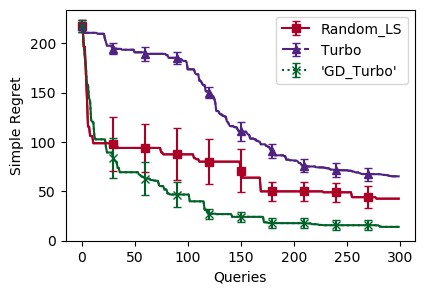

In [11]:
#mean=load_obj(func_name+'_Mean_'+'noisy_'+'Regret')
#error=load_obj(func_name+'_Error_'+'noisy_'+'Regret')
mean=load_obj(func_name+'_Mean_'+'Regret')
error=load_obj(func_name+'_Error_'+'Regret')
save_plot_T(mean,error)


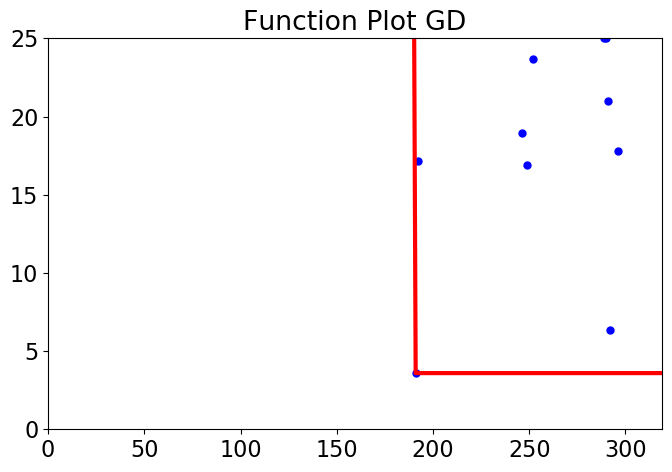

In [12]:
Bo_test.Y=Bo_test.Y*-1
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(Bo_test.Y, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(Bo_test.Y), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(Bo_test.Y)])
plt.ylim([0, 25])
plt.title("Function Plot GD")

plt.tight_layout()
plt.show()

In [13]:
print(time_opt/5) #time for one run of Turbo,GD

[ 80.74793448 104.26197453 111.4263927 ]
